# Colab Setup

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
"""
Change directory to where this file is located
"""
%cd ''

/Users/eunmi


In [4]:
import cv2
import PIL
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [5]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

Using PyTorch version: 1.13.0.dev20220628, Device: cpu


# Utils

In [6]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(np.transpose(image, (1, 2, 0)), aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

# Load Data: CIFAR-10

In [7]:
##먼저 CIFAR10가져오는 것 해보기
data = datasets.CIFAR10(root="./CIFAR_10", train=False, download=True) #이렇게 해보면 size등등이 나온다

print(data)
print("-----")
print(data[0]) #we're looking at first sample, output :  TUPLE [image, label] ()
#이 data는 loop도 돌릴 수 있는 것!

#we want to be able to do sth like
print(data[0], data[1], data[2]) #이런식으로 (ex : batch size 3) 해보고 싶다!

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./CIFAR_10
    Split: Test
-----
(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F7E304566D0>, 3)
(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F7E3010C9A0>, 3) (<PIL.Image.Image image mode=RGB size=32x32 at 0x7F7E3010C040>, 8) (<PIL.Image.Image image mode=RGB size=32x32 at 0x7F7E411BCEB0>, 8)


In [8]:
BATCH_SIZE = 32
EPOCHS = 10

In [9]:
class CustomDataset(Dataset):
    def __init__(self, train, transform=None, data_dir="./CIFAR_10"): #이미 있는 것을 가져온다
                        #train 이 argumejnt인 이뉴는 밑에 train=True, train= False냐에 따라서 train/test dataset어느거 가져오는지 달라져서
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def collate_fn(self, data):
        ###밑의 것이 왜 BATCH ? => data자체가 batch 갯수만큼만 되는 object일 것이기 떄문
        
        
        batch_x , batch_y = [], []
        
        #x, y individual image data/label을 tensorize해주기 
        for x, y in data: 
            #1. individual image data/label tensorize (and transform)
            if self.transform is not None: #i.e. transformation 지정된 것이 있따면 (ex : image augmentation)
                x = self.transform(x)
            x = transforms.ToTensor()(x)
            y = torch.Tensor([y]) #[] 붙이는 이유 : y자체는 long int여서 list 화 시킨후 그것을 tensor화 시켜야한다
            
            #2. add the individual images together to make a batch (실제로 BATCH인지는 확실하지 않다)
            batch_x.append(x)
            batch_y.append(y)
        batch_x = torch.stack(batch_x)
        batch_y = torch.cat(batch_y)
        
        #float,long화 (input/output이 올바른 datatype 이 되도록)
        batch_x = batch_x.float()
        batch_y = batch_y.long()
        return batch_x, batch_y

In [10]:
#참고로 위에서 한 tensorize하는 파트를 파헤쳐보면 밑에와 같다, 
x = transforms.ToTensor()(data[0][0])
y = torch.Tensor([data[0][1]])
print(x.shape, y.shape)
print(x , y)

torch.Size([3, 32, 32]) torch.Size([1])
tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 

In [11]:
## Load CIFAR-10 Dataset

train_dataset = CustomDataset(train = True)
test_dataset = CustomDataset(train = False)

train_loader = DataLoader(dataset = train_dataset, 
                          batch_size = BATCH_SIZE, 
                          shuffle = True, 
                          collate_fn = train_dataset.collate_fn)
test_loader = DataLoader(dataset = test_dataset, 
                         batch_size = BATCH_SIZE, 
                         shuffle = False, 
                         collate_fn = test_dataset.collate_fn)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
len(train_dataset), len(test_dataset) #5만, 1만장씩 있다!

(50000, 10000)

In [18]:
#loader : 로더 ,dataset : just datsaet
print(len(train_loader), len(test_loader))
print(len(train_dataset) / 32, len(test_dataset) / 32)
#round up한거랑 똑같다 => batch size로 잘 묶여졌다! ("batch 로 잘 묶여졌나 확인된다")

1563 313
1562.5 312.5


In [19]:

for X_train, y_train in train_dataset:
    print('X_train:', X_train, 'type:', type(X_train))
    print('y_train:', y_train, 'type:', type(y_train))
    break

X_train: <PIL.Image.Image image mode=RGB size=32x32 at 0x7F7E200D9880> type: <class 'PIL.Image.Image'>
y_train: 6 type: <class 'int'>


In [20]:

#바뀌기 전 shape
x = np.array(train_dataset[0][0])
print(x.shape)
print(transforms.ToTensor()(x).shape)

(32, 32, 3)
torch.Size([3, 32, 32])


In [21]:
#바뀐 후 shape 
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
    
    #바뀐후에 제대로 되었다는 것을 볼 수 있다! (transform.to_Tensor()이 확실히 일을 했다)

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


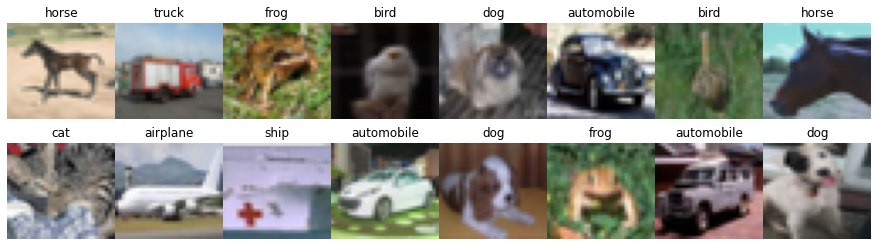

In [22]:
#실제로 보자
plot_dataset(train_loader)

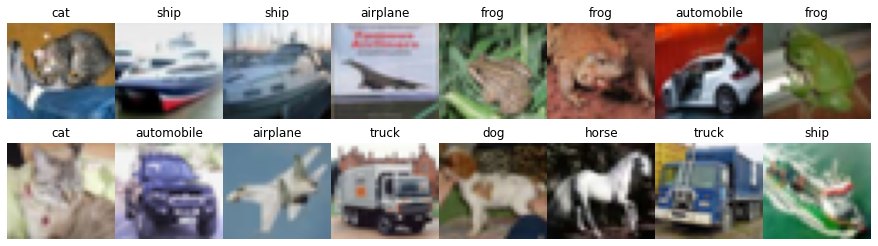

In [23]:
plot_dataset(test_loader)

# Multi-layer Perceptron(저번꺼랑 똑깥다, just baseline, 사실상 그냥 무싷기(맨 뒤로 옮기던지))

In [19]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim = 1)
        return x

In [20]:
model = MLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [21]:
def train(model, train_loader, optimizer, scheduler=None):
    model.train()
    train_loss = 0
    correct = 0
    tqdm_bar = tqdm(enumerate(train_loader))
    for batch_idx, (image, label) in tqdm_bar:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))
    if scheduler is not None:
        scheduler.step() # lr scheduler decays the learning rate every epoch
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_loss, train_acc

In [22]:
print(DEVICE)

mps


In [23]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc

In [24]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: MLP, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: MLP, 	Test Loss: 0.0663, 	Test Accuracy: 33.21 % 



0it [00:00, ?it/s]

KeyboardInterrupt: 

# Convolutional Neural Networks

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(6 * 6 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 6 * 6 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x)
        return x

In [25]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [26]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: CNN, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

0it [00:00, ?it/s]

/var/folders/m3/y3bh88f92_5d37clpvn8jg_00000gn/T/ipykernel_9157/2738653324.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: CNN, 	Test Loss: 0.0654, 	Test Accuracy: 36.41 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: CNN, 	Test Loss: 0.0635, 	Test Accuracy: 42.99 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: CNN, 	Test Loss: 0.0634, 	Test Accuracy: 42.88 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: CNN, 	Test Loss: 0.0626, 	Test Accuracy: 45.47 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: CNN, 	Test Loss: 0.0624, 	Test Accuracy: 46.46 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: CNN, 	Test Loss: 0.0617, 	Test Accuracy: 48.70 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: CNN, 	Test Loss: 0.0611, 	Test Accuracy: 50.52 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: CNN, 	Test Loss: 0.0612, 	Test Accuracy: 50.22 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: CNN, 	Test Loss: 0.0605, 	Test Accuracy: 52.27 % 



0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: CNN, 	Test Loss: 0.0609, 	Test Accuracy: 50.91 % 



# Learning Rate Tuning Examples



In [35]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(2 * 20, 4))
    plt.subplot(1, 6, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_loss'], label="train_loss")
    plt.plot(history['test_loss'], label="test_loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 6, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(history['train_acc'], label="train_acc")
    plt.plot(history['test_acc'], label="test_acc")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [36]:
BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0023, 	Test Accuracy: 12.07 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0023, 	Test Accuracy: 17.69 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0023, 	Test Accuracy: 23.45 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0022, 	Test Accuracy: 26.59 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0022, 	Test Accuracy: 27.98 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0022, 	Test Accuracy: 28.92 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0022, 	Test Accuracy: 29.64 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0022, 	Test Accuracy: 30.98 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0021, 	Test Accuracy: 33.25 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0021, 	Test Accuracy: 36.61 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 11], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0021, 	Test Accuracy: 40.57 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 12], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0020, 	Test Accuracy: 46.15 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 13], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0020, 	Test Accuracy: 52.35 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 14], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0019, 	Test Accuracy: 58.46 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 15], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0018, 	Test Accuracy: 63.95 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 16], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0018, 	Test Accuracy: 68.29 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 17], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0017, 	Test Accuracy: 71.65 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 18], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0016, 	Test Accuracy: 74.40 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 19], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0014, 	Test Accuracy: 76.36 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 20], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0013, 	Test Accuracy: 78.32 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 21], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0012, 	Test Accuracy: 79.22 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 22], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0011, 	Test Accuracy: 80.36 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 23], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0010, 	Test Accuracy: 81.37 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 24], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0009, 	Test Accuracy: 82.09 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 25], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0008, 	Test Accuracy: 82.76 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 26], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0008, 	Test Accuracy: 83.31 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 27], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0007, 	Test Accuracy: 83.91 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 28], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0007, 	Test Accuracy: 84.35 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 29], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0006, 	Test Accuracy: 84.71 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 30], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0006, 	Test Accuracy: 84.96 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 31], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0006, 	Test Accuracy: 85.50 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 32], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0005, 	Test Accuracy: 85.77 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 33], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0005, 	Test Accuracy: 86.01 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 34], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0005, 	Test Accuracy: 86.23 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 35], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0005, 	Test Accuracy: 86.54 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 36], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0005, 	Test Accuracy: 86.87 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 37], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0005, 	Test Accuracy: 87.05 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 38], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0005, 	Test Accuracy: 87.34 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 39], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 87.53 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 40], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 87.68 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 41], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 87.95 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 42], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 88.14 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 43], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 88.14 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 44], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 88.35 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 45], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 88.57 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 46], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 88.72 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 47], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 88.89 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 48], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 89.04 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 49], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 89.19 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 50], 	Model: MNIST NET, 	LR: 0.0010, 	Test Loss: 0.0004, 	Test Accuracy: 89.29 % 



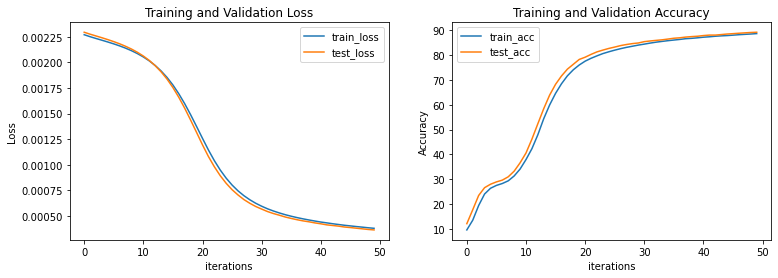

In [37]:
## adjust the learning rate and observe what happens

LR = 0.001

EPOCHS = 5
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[]}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: MNIST NET, \tLR: {:.4f}, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], test_loss, test_accuracy))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    
plot_history(history)

# Architectural Search

In [38]:
## Load CIFAR-10 Dataset

train_dataset = CustomDataset(train = True)
test_dataset = CustomDataset(train = False)

train_loader = DataLoader(dataset = train_dataset, 
                          batch_size = BATCH_SIZE, 
                          shuffle = True, 
                          collate_fn = train_dataset.collate_fn)
test_loader = DataLoader(dataset = test_dataset, 
                         batch_size = BATCH_SIZE, 
                         shuffle = False, 
                         collate_fn = test_dataset.collate_fn)

Files already downloaded and verified
Files already downloaded and verified


In [39]:
## see how the input shape changes after applying the layer

x = torch.randn(32, 3, 32, 32)
x = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)(x)
# x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
print(x.shape)

torch.Size([32, 8, 32, 32])


In [40]:
## Define your own CNN model - try various kinds of model designs

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        #### TODO ####

        ##############
        
    def forward(self, x):
        #### TODO ####

        ##############
        return x

In [41]:
model = MyCNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

## add lr scheduler
from torch.optim.lr_scheduler import ExponentialLR as ExponentialLR
scheduler = ExponentialLR(optimizer, gamma=0.9) #one of the learning rate schedulers
#scheduler.step()을 epoch 단위로 (not iteratino단위)로 해줘야한다!!(주의!!!)(epoch 별로 learning rate를 바꿀 것이니)

print(model)

ValueError: optimizer got an empty parameter list

In [42]:
## Experiment how your CNN works and compare the results

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: MY CNN, \tLR: {:.4f}, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, scheduler.get_last_lr()[0], test_loss, test_accuracy))


NameError: name 'scheduler' is not defined

# Data Augmentation

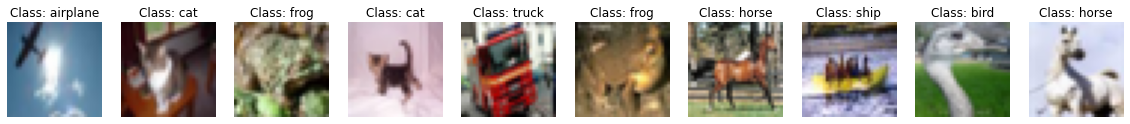

In [24]:
batch_x, batch_y = next(iter(train_loader))

pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(batch_x[i], (1, 2, 0)))
    plt.title('Class: ' + str(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][batch_y[i].item()]))

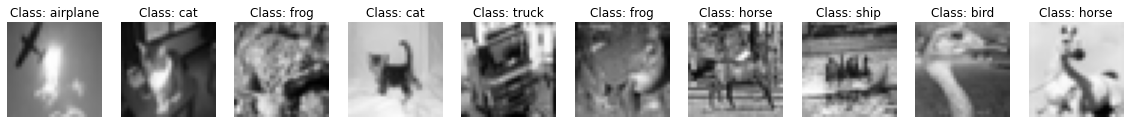

In [32]:
## PyTorch data augmentation - reference: https://pytorch.org/vision/master/transforms.html

#try different data augmentations by uncommenting and stuff 
augment = transforms.Grayscale(num_output_channels=3)
#augment = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
#augment = transforms.RandomHorizontalFlip(p=0.5)
#augment = transforms.RandomVerticalFlip(p=0.5)
#augment = transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))

pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(augment(batch_x[i]), (1, 2, 0))) #BATCH 단위로 AUGMENT!
    plt.title('Class: ' + str(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][batch_y[i].item()]))

In [34]:
##COMPOSE : 한꺼번에 sequential하게 tranform여러번 행하는 방법
augment_transform = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    # transforms.ToTensor(),
])

In [35]:
train_dataset = CustomDataset(train = True, transform = augment_transform)
test_dataset = CustomDataset(train = False, transform = augment_transform)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          collate_fn = train_dataset.collate_fn)
test_loader = DataLoader(dataset = test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False,
                         collate_fn = test_dataset.collate_fn)

Files already downloaded and verified
Files already downloaded and verified


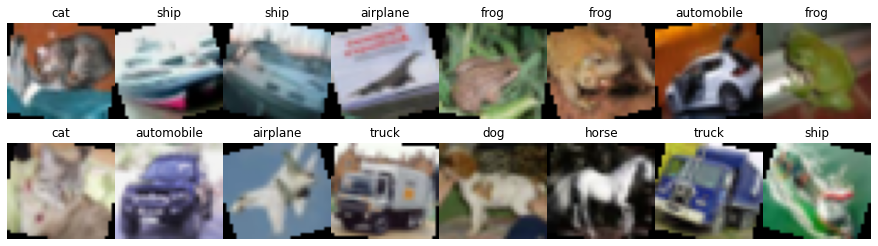

In [36]:
plot_dataset(test_loader)

In [37]:
for _ in range(len(test_loader)-1):
  next(iter(test_loader))

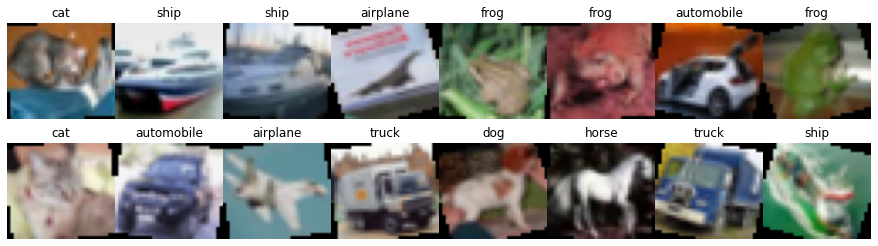

In [38]:
plot_dataset(test_loader) #다르게 transform되었다는 것을 볼 수 있다 (because random)

In [39]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

NameError: name 'CNN' is not defined

In [40]:
## compare the training results with the model trained without data augmentation

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: CNN, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

NameError: name 'train' is not defined

# Augment하면, 다양한 것을 보는 것이 뒤어서, 더 performance가 높아진다

Augment방법 두가지:
1. 5만장 하나 => transform두가지 더 해서 15만장은 input으로 보기
    * more computaiton, but less memory
2. 5만장만 하나, collate에서 transform을 시켜서, 5만장을 볼 때마다 transform된 (조금씩 달라진) 5만장을 본다
    * less computation, but more memory
    * 장점 : 매번 다르게 보기 떄문에, (즉, epoch때마다 random transform을 다시 시키니), 10번 epoch을 하면 10번 다르게 transform된 것들을 보기때문에 더 좋다

# Easier way to load CIFAR-10 data with data augmentation

In [ ]:
transform = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root = "./CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transform)

test_dataset = datasets.CIFAR10(root = "./CIFAR_10",
                                train = False,
                                download = True,
                                transform = transform)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True)
test_loader = DataLoader(dataset = test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False)

In [ ]:
## dataset outputs randomly augmented image every time

pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(np.transpose(train_dataset[0][0], (1,2,0)))
    plt.axis('off')